# Denoising Autoencoders

by Umberto Michelucci (umberto.michelucci@toelt.ai). 

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.constraints import max_norm

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np


In the next cell we defina some variables that will be useful later on.

In [10]:
# Model configuration
img_width, img_height = 28, 28
batch_size = 150        # Mini-batch size
no_epochs = 20          # How long the autoencoder should train.
validation_split = 0.2  # Percent of data to be used for validation.
verbosity = 1           # Keras option for debugging.
noise_factor = 0.55     # This scale the amout of noise we willl add.
number_of_visualizations = 6

Here we load the MNIST dataset, reshape it and normalized it. 

In [11]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

input_train = input_train.reshape((len(input_train), np.prod(input_train.shape[1:])))
input_test = input_test.reshape((len(input_test), np.prod(input_test.shape[1:])))

# Random Noise

We generate a ranomd matrix of noise, by sampling a normal (Gaussian) distribution.

$$
p(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

where $\mu$ is the mean, and $\sigma$ is the standard deviation. The shape of the function implies that sampling from it, will give more values around the mean than on the tails.

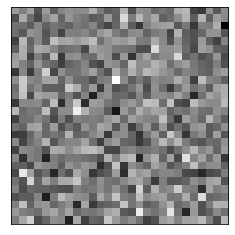

In [12]:
noise_img = np.random.normal(0, 1, (28,28))
plt.gray()
fig = plt.imshow(noise_img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [13]:
# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [19]:
# Create the model
input_img = Input(shape = (784,), name = 'Input_Layer')
# The layer encoded has a dimension equal to feature_layer_dim and contains
# the encoded input (therefore the name)
encoded = Dense(32, activation = 'relu', name = 'Encoded_Features')(input_img)
decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

encoded_input = Input(shape = (32,))
decoder = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder(encoded_input))



autoencoder.summary()
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model.png')

# Compile and fit data
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
Encoded_Features (Dense)     (None, 32)                25120     
_________________________________________________________________
Decoded_Input (Dense)        (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
320/320 [==============================] - 1s 3ms/step - loss: 0.2590 - val_loss: 0.1843
Epoch 2/20
320/320 [==============================] - 1s 2ms/step - loss: 0.1679 - val_loss: 0.1544
Epoch 3/20
320/320 [==============================] - 1s 2ms/step - loss: 0.1458 - val_loss: 0.1387
Epoch 4/20
320/320 [==============================] - 1s 2ms/step - loss: 0.1336

<Figure size 432x288 with 0 Axes>

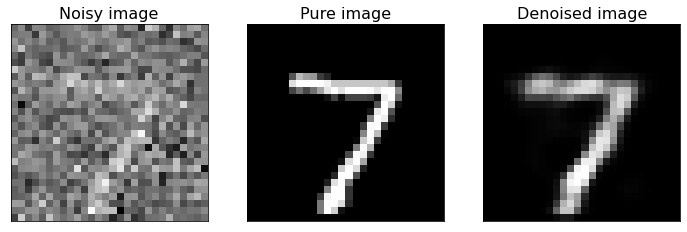

<Figure size 432x288 with 0 Axes>

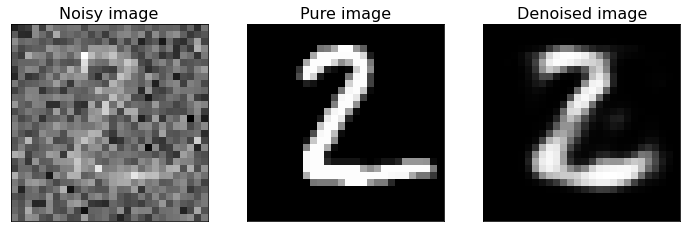

<Figure size 432x288 with 0 Axes>

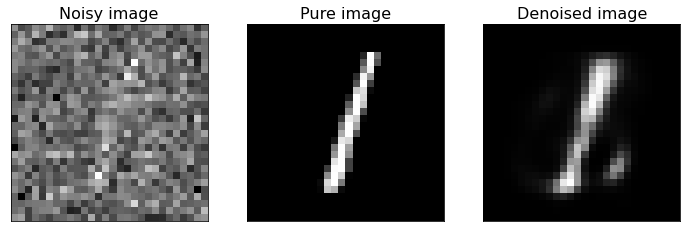

<Figure size 432x288 with 0 Axes>

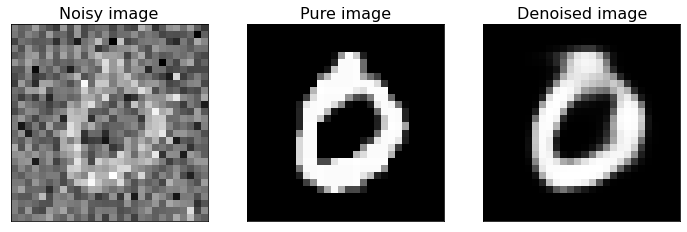

<Figure size 432x288 with 0 Axes>

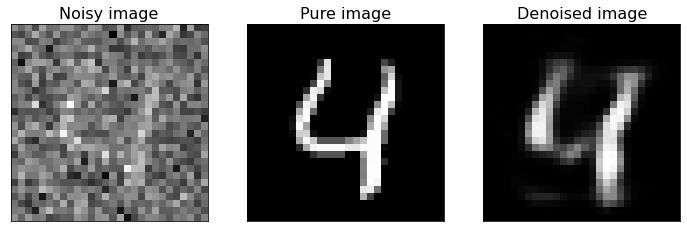

<Figure size 432x288 with 0 Axes>

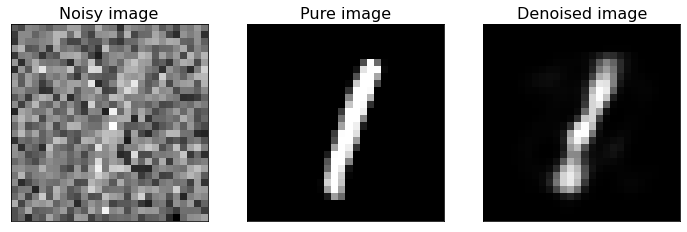

In [15]:
# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  plt.gray()
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i].reshape(28,28)
  pure_image  = pure_test[i].reshape(28,28)
  denoised_image = denoised_images[i].reshape(28,28)
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(12, 7)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image', fontsize = 16)
  axes[0].get_xaxis().set_visible(False)
  axes[0].get_yaxis().set_visible(False)
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image', fontsize = 16)
  axes[1].get_xaxis().set_visible(False)
  axes[1].get_yaxis().set_visible(False)
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image', fontsize = 16)
  axes[2].get_xaxis().set_visible(False)
  axes[2].get_yaxis().set_visible(False)
  #fig.suptitle(f'MNIST target = {input_class}', fontsize = 16)
 
  plt.show()

# Other noise types

In [16]:
# Add noise
pure = input_train
pure_test = input_test

mask = np.ones((28,28))
mask[0:14,:] = 0
mask = mask.reshape((1,784))
mask_test = np.repeat(mask, 10000, axis = 0)
mask_train = np.repeat(mask, 60000, axis = 0)

noise = np.multiply(np.random.normal(0, 1, pure.shape), mask_train)
noise_test = np.multiply(np.random.normal(0, 1, pure_test.shape), mask_test)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

# This is a different noise structure. We add noise only on half the image.

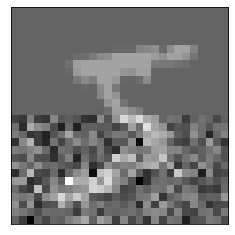

In [17]:
noise_img = noisy_input[0].reshape((28,28))
plt.gray()
fig = plt.imshow(noise_img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [32]:
# Create the model
input_img = Input(shape = (784,), name = 'Input_Layer')
# The layer encoded has a dimension equal to feature_layer_dim and contains
# the encoded input (therefore the name)
encoded = Dense(64, activation = 'relu', name = 'Encoded_Features')(input_img)
decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

encoded_input = Input(shape = (64,))
decoder = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder(encoded_input))



autoencoder.summary()
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model.png')

# Compile and fit data
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
Encoded_Features (Dense)     (None, 64)                50240     
_________________________________________________________________
Decoded_Input (Dense)        (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
320/320 [==============================] - 1s 3ms/step - loss: 0.2296 - val_loss: 0.1594
Epoch 2/30
320/320 [==============================] - 1s 3ms/step - loss: 0.1434 - val_loss: 0.1309
Epoch 3/30
320/320 [==============================] - 1s 3ms/step - loss: 0.1232 - val_loss: 0.1172
Epoch 4/30
320/320 [==============================] - 1s 3ms/step - loss: 0.1

<Figure size 432x288 with 0 Axes>

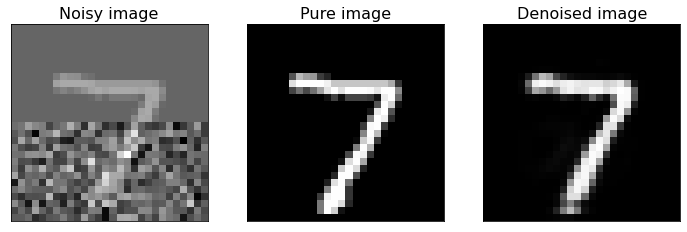

<Figure size 432x288 with 0 Axes>

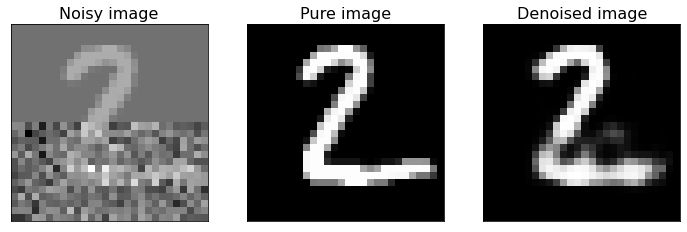

<Figure size 432x288 with 0 Axes>

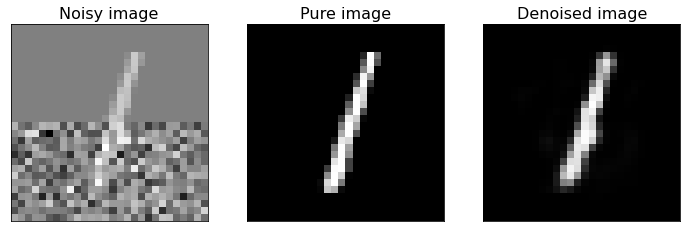

<Figure size 432x288 with 0 Axes>

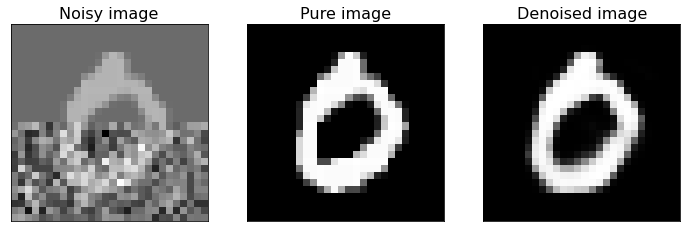

<Figure size 432x288 with 0 Axes>

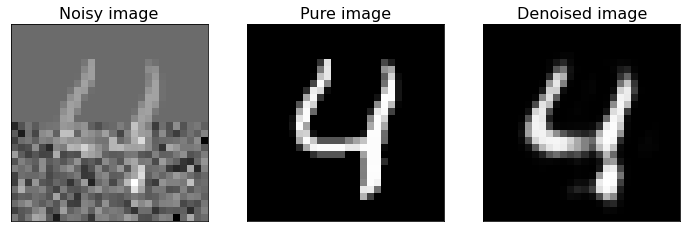

<Figure size 432x288 with 0 Axes>

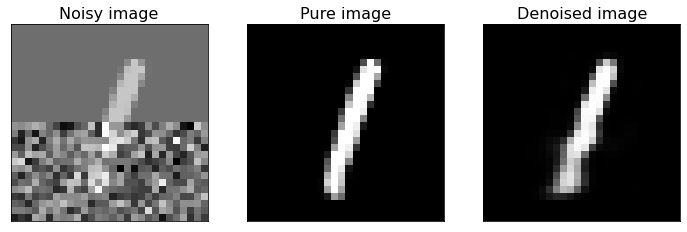

In [33]:


# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  plt.gray()
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i].reshape(28,28)
  pure_image  = pure_test[i].reshape(28,28)
  denoised_image = denoised_images[i].reshape(28,28)
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(12, 7)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image', fontsize = 16)
  axes[0].get_xaxis().set_visible(False)
  axes[0].get_yaxis().set_visible(False)
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image', fontsize = 16)
  axes[1].get_xaxis().set_visible(False)
  axes[1].get_yaxis().set_visible(False)
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image', fontsize = 16)
  axes[2].get_xaxis().set_visible(False)
  axes[2].get_yaxis().set_visible(False)
  #fig.suptitle(f'MNIST target = {input_class}', fontsize = 16)
 
  plt.show()

# Separating signals

In [55]:
# Add noise
pure = input_train
pure_test = input_test

mask = np.ones((28,28))*0.4
mask[0:14,:] = 0
mask = mask.reshape((1,784))
mask_test = np.repeat(mask, 10000, axis = 0)
mask_train = np.repeat(mask, 60000, axis = 0)

#noise = np.multiply(np.random.normal(0, 1, pure.shape), mask_train)
#noise_test = np.multiply(np.random.normal(0, 1, pure_test.shape), mask_test)
noisy_input = pure + mask_train
noisy_input_test = pure_test + mask_test

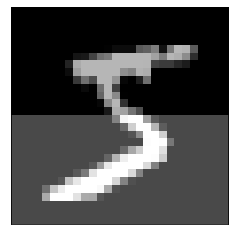

In [56]:
noise_img = noisy_input[0].reshape((28,28))
plt.gray()
fig = plt.imshow(noise_img)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [57]:
# Create the model
input_img = Input(shape = (784,), name = 'Input_Layer')
# The layer encoded has a dimension equal to feature_layer_dim and contains
# the encoded input (therefore the name)
encoded = Dense(64, activation = 'relu', name = 'Encoded_Features')(input_img)
decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

encoded_input = Input(shape = (64,))
decoder = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder(encoded_input))



autoencoder.summary()
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model.png')

# Compile and fit data
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
Encoded_Features (Dense)     (None, 64)                50240     
_________________________________________________________________
Decoded_Input (Dense)        (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
320/320 [==============================] - 1s 3ms/step - loss: 0.2242 - val_loss: 0.1560
Epoch 2/30
320/320 [==============================] - 1s 2ms/step - loss: 0.1356 - val_loss: 0.1205
Epoch 3/30
320/320 [==============================] - 1s 2ms/step - loss: 0.1107 - val_loss: 0.1040
Epoch 4/30
320/320 [==============================] - 1s 2ms/step - loss: 0.0

<Figure size 432x288 with 0 Axes>

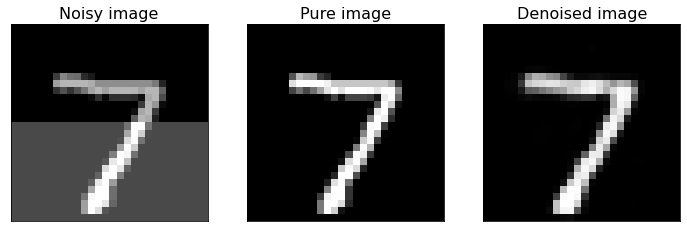

<Figure size 432x288 with 0 Axes>

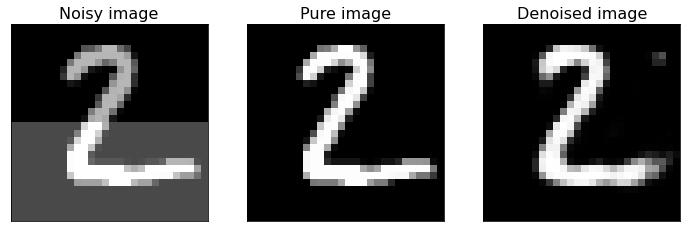

<Figure size 432x288 with 0 Axes>

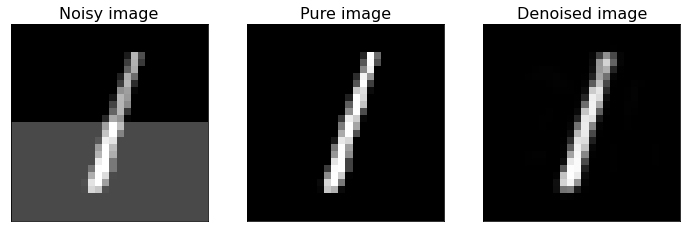

<Figure size 432x288 with 0 Axes>

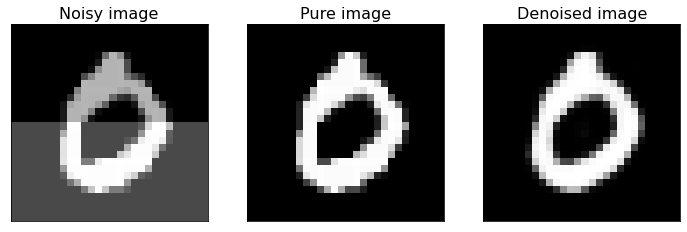

<Figure size 432x288 with 0 Axes>

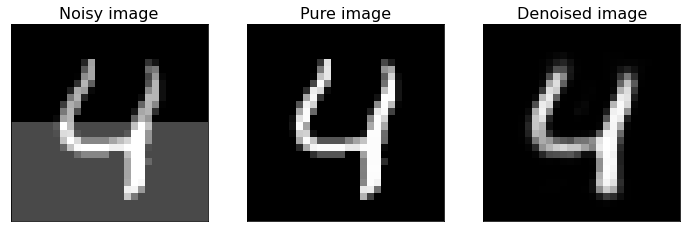

<Figure size 432x288 with 0 Axes>

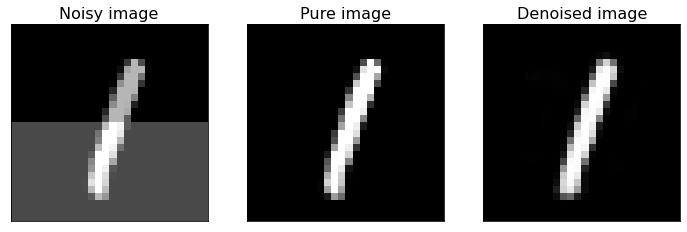

In [58]:


# Generate denoised images
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder.predict(samples)

# Plot denoised images
for i in range(0, number_of_visualizations):
  plt.gray()
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i].reshape(28,28)
  pure_image  = pure_test[i].reshape(28,28)
  denoised_image = denoised_images[i].reshape(28,28)
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(12, 7)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image', fontsize = 16)
  axes[0].get_xaxis().set_visible(False)
  axes[0].get_yaxis().set_visible(False)
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image', fontsize = 16)
  axes[1].get_xaxis().set_visible(False)
  axes[1].get_yaxis().set_visible(False)
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image', fontsize = 16)
  axes[2].get_xaxis().set_visible(False)
  axes[2].get_yaxis().set_visible(False)
  #fig.suptitle(f'MNIST target = {input_class}', fontsize = 16)
 
  plt.show()

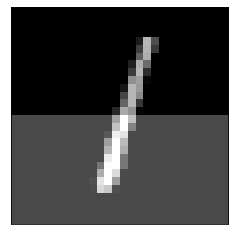

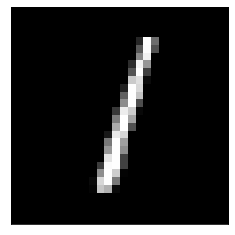

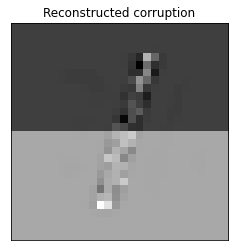

In [62]:
noisy_image = noisy_input_test[2].reshape(28,28)
pure_image  = pure_test[2].reshape(28,28)
denoised_image = denoised_images[2].reshape(28,28)

error_reconstructed = noisy_image-denoised_image

residuals = np.abs(noisy_image - error_reconstructed)


plt.gray()
fig = plt.imshow(noisy_image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

plt.gray()
fig = plt.imshow(pure_image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

plt.gray()
fig = plt.imshow(error_reconstructed)
plt.title ("Reconstructed corruption")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

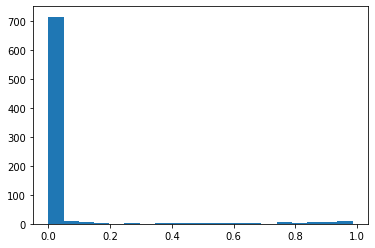

In [63]:
plt.hist(residuals.ravel(), bins = 20)
plt.show()

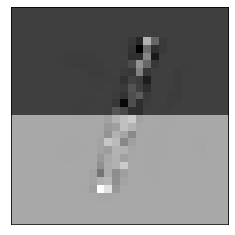

In [64]:
plt.gray()
fig = plt.imshow(error_reconstructed)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)